In [ ]:
from typing import List, TypedDict
import re

from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph, START, END
from pydantic import BaseModel
from dotenv import load_dotenv

load_dotenv()

In [ ]:
docs = (
    PyPDFLoader("./documents/book1.pdf").load()
    + PyPDFLoader("./documents/book2.pdf").load()
    + PyPDFLoader("./documents/book3.pdf").load()
)

In [ ]:
chunks = RecursiveCharacterTextSplitter(chunk_size=900, chunk_overlap=150).split_documents(docs)
for d in chunks:
    d.page_content = d.page_content.encode("utf-8", "ignore").decode("utf-8", "ignore")

In [ ]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")
vector_store = FAISS.from_documents(chunks, embeddings)
retriever = vector_store.as_retriever(search_type="similarity", search_kwargs={"k": 4})

In [ ]:
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

In [ ]:
class State(TypedDict):
    question: str
    docs: List[Document]

    strips: List[str]            # output of decomposition (sentence strips)
    kept_strips: List[str]       # after filtering (kept sentences)
    refined_context: str         # recomposed internal knowledge (joined kept_strips)

    answer: str

In [ ]:
def retrieve(state: State) -> State:
    q = state["question"]
    return {"docs": retriever.invoke(q)}

In [ ]:
# -----------------------------
# Sentence-level DECOMPOSER
# -----------------------------
def decompose_to_sentences(text: str) -> List[str]:
    text = re.sub(r"\s+", " ", text).strip()
    sentences = re.split(r"(?<=[.!?])\s+", text)
    return [s.strip() for s in sentences if len(s.strip()) > 20]


# -----------------------------
# FILTER (LLM judge)
# -----------------------------
class KeepOrDrop(BaseModel):
    keep: bool

filter_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a strict relevance filter.\n"
            "Return keep=true only if the sentence directly helps answer the question.\n"
            "Use ONLY the sentence. Output JSON only.",
        ),
        ("human", "Question: {question}\n\nSentence:\n{sentence}"),
    ]
)

filter_chain = filter_prompt | llm.with_structured_output(KeepOrDrop)


# -----------------------------
# REFINING (Decompose -> Filter -> Recompose)
# -----------------------------
def refine(state: State) -> State:

    q = state["question"]

    # Combine retrieved docs into one context string
    context = "\n\n".join(d.page_content for d in state["docs"]).strip()

    # 1) DECOMPOSITION: context -> sentence strips
    strips = decompose_to_sentences(context)

    # 2) FILTER: keep only relevant strips
    kept: List[str] = []
    
    for s in strips:
        if filter_chain.invoke({"question": q, "sentence": s}).keep:
            kept.append(s)

    # 3) RECOMPOSE: glue kept strips back together (internal knowledge)
    refined_context = "\n".join(kept).strip()

    return {
        "strips": strips,
        "kept_strips": kept,
        "refined_context": refined_context,
    }


In [ ]:
answer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful ML tutor. Answer ONLY using the provided refined bullets.\n"
            "If the bullets are empty or insufficient, say: 'I don't know based on the provided books.'",
        ),
        ("human", "Question: {question}\n\nRefined context:\n{refined_context}"),
    ]
)

def generate(state: State) -> State:
    out = (answer_prompt | llm).invoke({"question": state["question"], "refined_context": state['refined_context']})
    return {"answer": out.content}

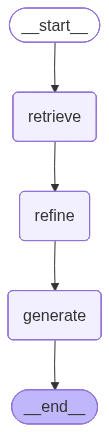

In [23]:
g = StateGraph(State)
g.add_node("retrieve", retrieve)
g.add_node("refine", refine)
g.add_node("generate", generate)

g.add_edge(START, "retrieve")
g.add_edge("retrieve", "refine")
g.add_edge("refine", "generate")
g.add_edge("generate", END)

app = g.compile()

app

In [24]:
res = app.invoke({
    "question": "Explain the bias–variance tradeoff",
    "docs": [],
    "strips": [],
    "kept_strips": [],
    "refined_context": "",
    "answer": ""
})
print(res["answer"])

The bias–variance tradeoff is a fundamental concept in statistics and machine learning that describes the relationship between a model's complexity and its generalization error. 

- **Bias**: This error arises from incorrect assumptions in the learning algorithm, such as assuming linearity when the true relationship is quadratic. High-bias models tend to underfit the training data.
  
- **Variance**: This error is due to the model's sensitivity to small fluctuations in the training data. High-variance models can overfit the training data.

- The generalization error can be expressed as the sum of bias, variance, and a constant noise term.

- There is a trade-off between bias and variance: flexible models have low bias and high variance, while rigid models have high bias and low variance.

- The optimal model achieves the best balance between bias and variance.

- Increasing model complexity typically raises variance and lowers bias, while reducing complexity increases bias and lowers v

In [25]:
print(res['docs'][0].page_content)
print('*'*100)
print(res['docs'][1].page_content)
print('*'*100)
print(res['docs'][2].page_content)
print('*'*100)
print(res['docs'][3].page_content)

10 This notion of bias is not to be confused with the bias term of linear models.
Figure 4-16. Learning curves for the polynomial model
One way to improve an overfitting model is to feed it more training
da
ta until the validation error reaches the training error.
The Bias/Variance Tradeoff
An importan
t theoretical result of statistics and Machine Learning is the fact that a
model’s generaliza
tion error can be expressed as the sum of three very different
errors:
Bias
This part of the generalization error is due to wrong assumptions, such as assum‐
ing that the data is linear when it is actually quadratic. A high-bias model is most
likely to underfit the training data.10
Variance
This part is due to the model’s excessive sensitivity to small variations in the
training data. A model with many degrees of freedom (such as a high-degree pol‐
****************************************************************************************************
and the bias and variance terms now refer to int

In [27]:
print(res['refined_context'])

The Bias/Variance Tradeoff An importan t theoretical result of statistics and Machine Learning is the fact that a model’s generaliza tion error can be expressed as the sum of three very different errors: Bias This part of the generalization error is due to wrong assumptions, such as assum‐ ing that the data is linear when it is actually quadratic.
A high-bias model is most likely to underfit the training data.10 Variance This part is due to the model’s excessive sensitivity to small variations in the training data.
Our goal is to minimize the expected loss, which we have decomposed into the sum of a (squared) bias, a variance, and a constant noise term.
As we shall see, there is a trade-off between bias and variance, with very ﬂexible models having low bias and high variance, and relatively rigid models having high bias and low variance.
The model with the optimal predictive capability is the one that leads to the best balance between bias and variance.
Increasing a model’s complexity 

In [21]:
def decompose_to_sentences(text: str) -> List[str]:
    text = re.sub(r"\s+", " ", text).strip()
    sentences = re.split(r"(?<=[.!?])\s+", text)
    return [s.strip() for s in sentences if len(s.strip()) > 20]

In [22]:
decompose_to_sentences("""A transformer in deep learning is a type of model architecture that is particularly effective for processing sequential data, such as text. It utilizes mechanisms called self-attention and feedforward neural networks to weigh the importance of different parts of the input data, allowing it to capture long-range dependencies and relationships within the data. Unlike traditional recurrent neural networks (RNNs), transformers do not process data sequentially, which enables them to be more parallelizable and efficient in training. This architecture has become foundational in natural language processing tasks and has led to significant advancements in the field.""")

['A transformer in deep learning is a type of model architecture that is particularly effective for processing sequential data, such as text.',
 'It utilizes mechanisms called self-attention and feedforward neural networks to weigh the importance of different parts of the input data, allowing it to capture long-range dependencies and relationships within the data.',
 'Unlike traditional recurrent neural networks (RNNs), transformers do not process data sequentially, which enables them to be more parallelizable and efficient in training.',
 'This architecture has become foundational in natural language processing tasks and has led to significant advancements in the field.']